# Import libraries

In [1]:
import scipy.io as sio
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from numpy import mean, std
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import time
import torch
from torch import nn
from torch.autograd import Variable

import math
import time
from tqdm.notebook import tqdm
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from collections import Counter

from Resnet_1d import *
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from open_dataset import open_file, count_and_plot
#from train_model import Exe_Model
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

# Check GPU Availability

In [2]:
use_cuda = torch.cuda.is_available()
lct = 'GPU' if use_cuda else 'CPU'
print('Location of Deep learning processed:', lct)

Location of Deep learning processed: GPU


# Load dataset

## For non-divided dataset

In [ ]:
dataset_path = '512_colorectal.csv'
train_data_loader, test_data_loader, num_train_instances, num_test_instances, n_cat = open_file(dataset_path)

## For pre-divded dataset

In [ ]:
for idx, phase in enumerate(['train', 'test']):
    dataset_path = '512_indianfruits_' + phase + '.csv'
    if phase == 'train':
        train_data_loader, num_train_instances, n_cat = open_file(dataset_path, split=False, phase=phase)
    elif phase == 'test':
        test_data_loader, num_test_instances, n_cat = open_file(dataset_path, split=False, phase=phase)

# Run Models

In [ ]:
model=Exe_Model(MSResNet)

In [ ]:
model.set_model(n_cat)
model.train_model(train_data_loader, test_data_loader, num_train_instances, num_test_instances, es_tolerance=50)

In [ ]:
print(model.best_acc)
print(model.epoch_atbest)
print(model.current_epoch)
print(model.train_time)

#print(set_result)
#count_and_plot(acc_result)

In [ ]:
model.repeat_train(n_repeat=20)

In [ ]:
print(model.repeat_acc)
print(model.repeat_epoch)

In [ ]:
model.cm()
model.result()

In [ ]:
emodel = torch.load(model.PATH+'model.pt')
emodel.load_state_dict(torch.load(model.PATH+'model_state_dict.pt'))

checkpoint = torch.load(model.PATH+'all.tar')
emodel.load_state_dict(checkpoint['model'])
model.optimizer.load_state_dict(checkpoint['optimizer'])
#emodel.eval(test_data_loader)

# Compare 1D ResNet and sklearn ML

In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = ['SVC', 'RandomForest', 'knn', 'DecisionTree', 'GradientBoosting', 'XgBoost', 'LightGBM']

In [16]:
def count_and_plot2(y): 
    C = Counter(y)
    print(C)
    sorted_C=sorted(C.items(), key=lambda x:(-x[1], x[0]))
    counter=sorted(sorted_C)
    key = []
    value = []
    for k,v in enumerate(counter):
        #print('Class=%d, n=%d (%.3f%%)' % (v[0], v[1], v[1] / len(y) * 100), 'weight=', len(y)/v[1])
        key.append(v[0])
        value.append(round(v[1], 4))
    #plt.bar(key, value)
    #plt.xlabel('Labels')
    #plt.show()
    
    tick_size = 13 ## 눈금 폰트 사이즈
    axis_label_size = 15 ## x축, y축 폰트 사이즈

    fig = plt.figure(figsize=(10,10)) ## Figure 생성 사이즈는 10 by 10
    ax = fig.add_subplot() ## Axes 추가
    colors = sns.color_palette('hls',len(key)) ## 색상 지정

    xtick_label_position = list(range(len(key))) ## x축 눈금 라벨이 표시될 x좌표

    plt.yticks(fontsize=tick_size)
    plt.xticks(xtick_label_position, key, fontsize=tick_size, rotation=90) ## x축 눈금 라벨 출력

    bars = plt.bar(xtick_label_position, value, color=colors, \
                   edgecolor=colors, alpha=0.7, linewidth=1) ## 바차트 출력

    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.01, \
                value[i],ha='center',fontsize=13)

    #plt.title('지난달 연령별 방문환자 수',fontsize=20) ## 타이틀 출력
    plt.xlabel('Labels',fontsize=axis_label_size) ## x축 라벨 출력
    #plt.ylabel('방문환자수',fontsize=axis_label_size) ## y축 라벨 출력
    plt.show()

       img  label     glcm1     glcm2     glcm3     glcm4     glcm5     glcm6  \
0  10515.0    9.0  0.515894  0.504506  0.512995  0.504683  0.506722  0.504506   

      glcm7     glcm8  ...  dim1_f134  dim1_f135  dim1_f136  dim1_f137  \
0  0.500906  0.504683  ...        0.0        0.0        0.0        0.0   

   dim1_f138  dim1_f139  dim1_f140  dim1_f141  dim1_f142  dim1_f143  
0        0.0        0.0        0.0        0.0        0.0        0.0  

[1 rows x 514 columns]
Counter({9.0: 6000, 5.0: 6000, 3.0: 6000, 8.0: 6000, 6.0: 6000, 1.0: 6000, 7.0: 6000, 4.0: 6000, 2.0: 6000, 0.0: 6000})


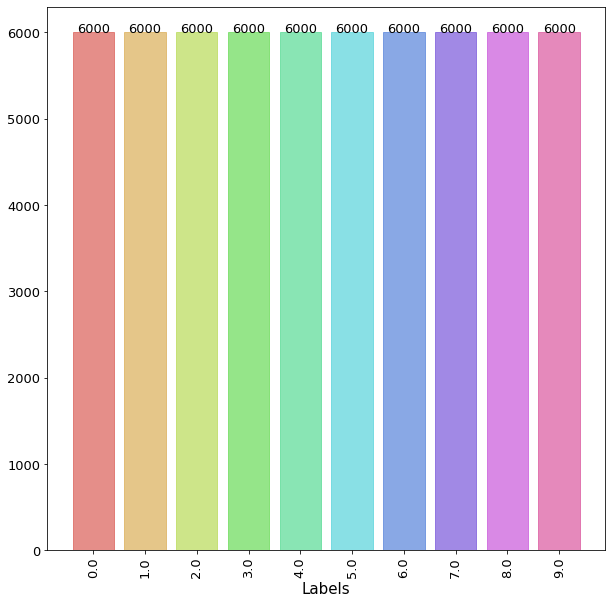

label data shape: (60000,)
Original data shape: (60000, 512)
Test data shape:  torch.Size([12000, 1, 512])


In [23]:
acc_result={}
time_result={}
f1_result={}

dataset_path = '512_fmnist.csv'
train_data_loader, test_data_loader, num_train_instances, num_test_instances, n_cat = open_file(dataset_path)

data = pd.read_csv(dataset_path)
dataset = data.sample(frac=1).reset_index(drop=True)
dataset = dataset.fillna(0)
X_len = len(dataset.columns)
X = dataset.iloc[:, 3:X_len].values if X_len==515 else dataset.iloc[:, 2:X_len].values
y = dataset.iloc[:, 2].values if X_len==515 else dataset.iloc[:, 1].values
if np.min(y) > 0: 
    y = y-np.min(y)
n_cat = int(max(y))+1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, shuffle=True)

model loaded


/home/seung-ho/anaconda3/envs/cubical/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/seung-ho/anaconda3/envs/cubical/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:117: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Epoch: 0
Training accuracy: 55.66458333333333
val accuracy: 55.108333333333334
F1 score: 0.5151321615792366



Epoch: 1
Training accuracy: 49.010416666666664
val accuracy: 48.983333333333334
F1 score: 0.4440745666937901



Epoch: 2
Training accuracy: 53.28541666666667
val accuracy: 53.19166666666667
F1 score: 0.5266395645311831



Epoch: 3
Training accuracy: 71.29375
val accuracy: 70.53333333333333
F1 score: 0.701852962108973



Epoch: 4
Training accuracy: 69.30625
val accuracy: 68.8
F1 score: 0.6806357651649092



Epoch: 5
Training accuracy: 51.43125
val accuracy: 51.45
F1 score: 0.46407360434212114



Epoch: 6
Training accuracy: 63.12708333333333
val accuracy: 61.84166666666667
F1 score: 0.6167935942124796



Epoch: 7
Training accuracy: 53.5375
val accuracy: 53.125
F1 score: 0.5088031940752566



Epoch: 8
Training accuracy: 58.8875
val accuracy: 57.958333333333336
F1 score: 0.5688247021364378



Epoch: 9
Training accuracy: 58.65416666666667
val accuracy: 57.85
F1 score: 0.544414737116062



Epoch: 10
Training accuracy: 65.58958333333334
val accuracy: 65.08333333333333
F1 score: 0.6383023703436979



Epoch: 11
Training accuracy: 69.15833333333333
val accuracy: 67.15
F1 score: 0.6675281644284897



Epoch: 12
Training accuracy: 69.3875
val accuracy: 67.84166666666667
F1 score: 0.6733162850268357



Epoch: 13
Training accuracy: 72.26875
val accuracy: 70.375
F1 score: 0.7080035209522287



Epoch: 14
Training accuracy: 74.725
val accuracy: 72.15
F1 score: 0.7216492718459699



Epoch: 15
Training accuracy: 63.7375
val accuracy: 61.641666666666666
F1 score: 0.6112234064405936



Epoch: 16
Training accuracy: 65.9875
val accuracy: 63.84166666666667
F1 score: 0.6229038918804076



Epoch: 17
Training accuracy: 67.74166666666666
val accuracy: 65.06666666666666
F1 score: 0.63618976010386



Epoch: 18
Training accuracy: 65.73958333333333
val accuracy: 62.733333333333334
F1 score: 0.6198699656852472



Epoch: 19
Training accuracy: 58.08541666666667
val accuracy: 55.858333333333334
F1 score: 0.5592329409153998



Epoch: 20
Training accuracy: 72.72291666666666
val accuracy: 68.51666666666667
F1 score: 0.6857380476166883



Epoch: 21
Training accuracy: 64.3125
val accuracy: 59.583333333333336
F1 score: 0.575164669028821



Epoch: 22
Training accuracy: 45.93333333333333
val accuracy: 44.275
F1 score: 0.37726341609791103



Epoch: 23
Training accuracy: 49.69375
val accuracy: 47.358333333333334
F1 score: 0.4234919628224602



Epoch: 24
Training accuracy: 74.975
val accuracy: 68.68333333333334
F1 score: 0.6743974911546602



Epoch: 25
Training accuracy: 71.45208333333333
val accuracy: 64.60833333333333
F1 score: 0.6365485154485587



Epoch: 26
Training accuracy: 84.07708333333333
val accuracy: 73.68333333333334
F1 score: 0.7361978695534065



Epoch: 27
Training accuracy: 77.5
val accuracy: 67.86666666666666
F1 score: 0.6831020627330869



Epoch: 28
Training accuracy: 79.99791666666667
val accuracy: 70.375
F1 score: 0.7035839681725908



Epoch: 29
Training accuracy: 74.16041666666666
val accuracy: 64.375
F1 score: 0.6531448312493171



Epoch: 30
Training accuracy: 76.42916666666666
val accuracy: 63.93333333333333
F1 score: 0.6343567357385465



Epoch: 31
Training accuracy: 71.71875
val accuracy: 61.30833333333333
F1 score: 0.5985866192822411



Epoch: 32
Training accuracy: 74.28541666666666
val accuracy: 61.65
F1 score: 0.6132963260757625



Epoch: 33
Training accuracy: 83.59375
val accuracy: 67.68333333333334
F1 score: 0.6768950354255971



Epoch: 34
Training accuracy: 73.87708333333333
val accuracy: 59.61666666666667
F1 score: 0.5953208311740885



Epoch: 35
Training accuracy: 87.57083333333334
val accuracy: 68.54166666666667
F1 score: 0.6827878519128631



Epoch: 36
Training accuracy: 83.72083333333333
val accuracy: 66.69166666666666
F1 score: 0.673337275835249



Epoch: 37
Training accuracy: 78.56875
val accuracy: 62.675
F1 score: 0.623326160285851



Epoch: 38
Training accuracy: 66.12291666666667
val accuracy: 52.40833333333333
F1 score: 0.5119298337545993



Epoch: 39
Training accuracy: 78.28541666666666
val accuracy: 59.68333333333333
F1 score: 0.5926300935060096



Epoch: 40
Training accuracy: 88.99583333333334
val accuracy: 66.125
F1 score: 0.6681754981221517



Epoch: 41
Training accuracy: 87.175
val accuracy: 65.29166666666667
F1 score: 0.6506568853574244



Epoch: 42
Training accuracy: 84.96875
val accuracy: 64.71666666666667
F1 score: 0.6535491711603928



Epoch: 43
Training accuracy: 89.12916666666666
val accuracy: 65.93333333333334
F1 score: 0.6520422194124413



Epoch: 44
Training accuracy: 96.09166666666667
val accuracy: 71.36666666666666
F1 score: 0.7116133668214674



Epoch: 45
Training accuracy: 43.639583333333334
val accuracy: 36.375
F1 score: 0.3332431785994027



Epoch: 46
Training accuracy: 90.14166666666667
val accuracy: 67.28333333333333
F1 score: 0.6829569708361843

 Best validation accuracy: 0.7368333333333333    when epoch: 26
triain time: 467.12322878837585


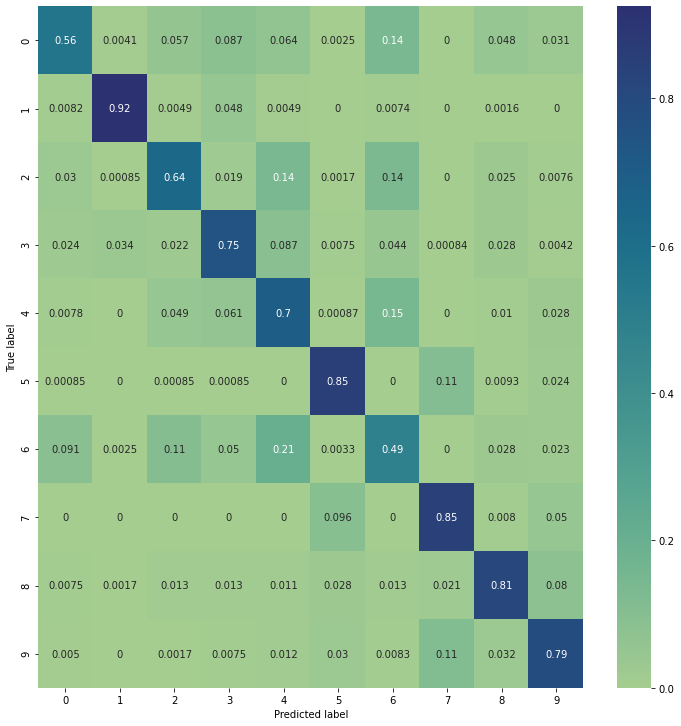

In [24]:
model=Exe_Model(MSResNet)
model.set_model(n_cat)
model.train_model(train_data_loader, test_data_loader, num_train_instances, num_test_instances, es_tolerance=20)
model.cm()

acc_result['1D_ResNet'] = model.best_acc
time_result['1D_ResNet'] = model.train_time
f1_result['1D_ResNet'] = model.f1score

In [25]:
for idx, sk_model in tqdm(enumerate(models)):
    if sk_model=='SVC':
        train_model=SVC(kernel='rbf', C = 10, gamma=0.001)
    elif sk_model=='RandomForest':
        train_model=RandomForestClassifier(criterion='gini', n_estimators=200, random_state=4, n_jobs=10)
    elif sk_model=='knn':
        train_model=KNeighborsClassifier(n_neighbors = n_cat)
    elif sk_model=='DecisionTree':
        train_model=DecisionTreeClassifier(random_state=10)
    elif sk_model=='GradientBoosting':
        train_model=GradientBoostingClassifier(random_state=10)
    elif sk_model=='XgBoost':
        train_model=XGBClassifier(n_estimators=1000)
    elif sk_model=='LightGBM':
        train_model=LGBMClassifier(n_estimators=1000)
    start = time.time()
    train_model.fit(X_train, y_train)
    time_result[sk_model]=time.time() - start
    y_pred = train_model.predict(X_test)
    acc_result[sk_model]=accuracy_score(y_test, y_pred)
    f1_result[sk_model]=f1_score(y_test, y_pred, average='weighted')

{'1D_ResNet': 467.12326836586, 'SVC': 935.2069072723389, 'RandomForest': 7.659602403640747, 'knn': 3.378364086151123, 'DecisionTree': 8.3752281665802, 'GradientBoosting': 1808.0719537734985, 'XgBoost': 1108.1968343257904, 'LightGBM': 89.36505722999573}
{'1D_ResNet': 0.7361978695534065, 'SVC': 0.5285052527927679, 'RandomForest': 0.6919095009393725, 'knn': 0.39032742778391866, 'DecisionTree': 0.5668261194456518, 'GradientBoosting': 0.6943256475245136, 'XgBoost': 0.7459476772982694, 'LightGBM': 0.7485450266835137}
Counter({'LightGBM': 0.7478333333333333, 'XgBoost': 0.7459166666666667, '1D_ResNet': 0.7368333333333333, 'GradientBoosting': 0.6958333333333333, 'RandomForest': 0.69275, 'DecisionTree': 0.5666666666666667, 'SVC': 0.53475, 'knn': 0.39725})


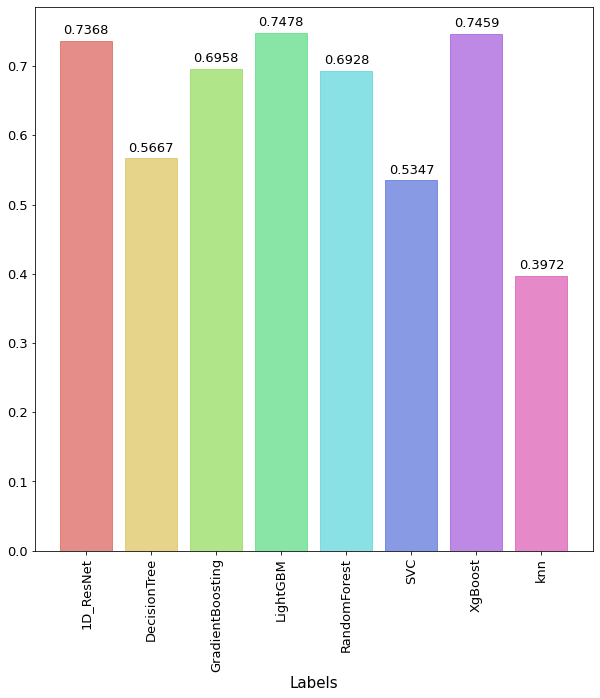

In [26]:
print(time_result)
print(f1_result)
count_and_plot2(acc_result)

      img  label     glcm1     glcm2     glcm3     glcm4     glcm5     glcm6  \
0  3562.0    0.0  0.512562  0.508774  0.513654  0.508886  0.505305  0.508774   

      glcm7     glcm8  ...  dim1_f134  dim1_f135  dim1_f136  dim1_f137  \
0  0.507518  0.508886  ...   1.066969   1.066752   1.066652   1.065967   

   dim1_f138  dim1_f139  dim1_f140  dim1_f141  dim1_f142  dim1_f143  
0   1.065337   1.064717   1.064397   1.064017   1.062415   1.062267  

[1 rows x 514 columns]
Counter({0.0: 1805, 2.0: 999, 1.0: 370, 4.0: 295, 3.0: 193})


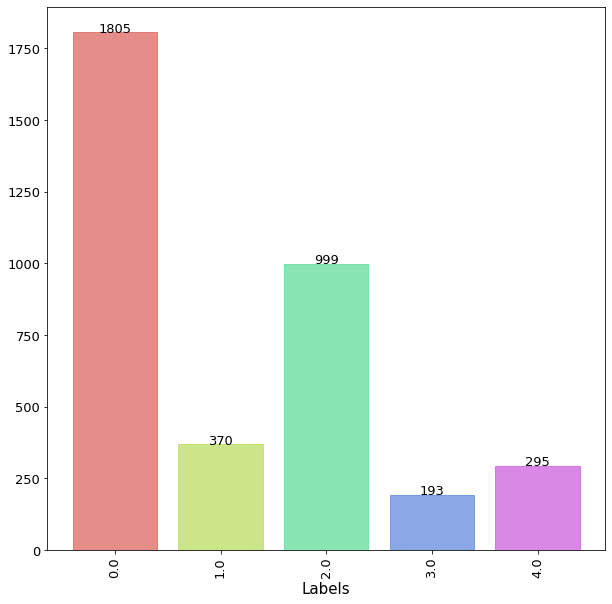

label data shape: (3662,)
Original data shape: (3662, 512)
Test data shape:  torch.Size([733, 1, 512])
model loaded


/home/seung-ho/anaconda3/envs/cubical/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/seung-ho/anaconda3/envs/cubical/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:117: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Epoch: 0
Training accuracy: 7.98907476954592
val accuracy: 9.140518417462483
F1 score: 0.017752916052260953



Epoch: 1
Training accuracy: 64.56128371457835
val accuracy: 64.5293315143247
F1 score: 0.6305347006118377



Epoch: 2
Training accuracy: 65.68794810515534
val accuracy: 62.755798090040926
F1 score: 0.5710700953893679



Epoch: 3
Training accuracy: 69.54592010925231
val accuracy: 68.4856753069577
F1 score: 0.5970396048857124



Epoch: 4
Training accuracy: 66.16592693752133
val accuracy: 63.84720327421555
F1 score: 0.5728631924588526



Epoch: 5
Training accuracy: 68.48753840901331
val accuracy: 66.84856753069577
F1 score: 0.5983217325595678



Epoch: 6
Training accuracy: 73.02833731649027
val accuracy: 69.98635743519782
F1 score: 0.6534411427013163



Epoch: 7
Training accuracy: 71.83339023557528
val accuracy: 69.57708049113234
F1 score: 0.6300676130291857



Epoch: 8
Training accuracy: 70.2628883578013
val accuracy: 65.21145975443383
F1 score: 0.6156212130150127



Epoch: 9
Training accuracy: 71.73096620006828
val accuracy: 70.12278308321964
F1 score: 0.6266842740183725



Epoch: 10
Training accuracy: 57.01604643222943
val accuracy: 54.02455661664393
F1 score: 0.4363786201257317



Epoch: 11
Training accuracy: 74.63298053943325
val accuracy: 69.03137789904503
F1 score: 0.6694774671562793



Epoch: 12
Training accuracy: 74.39399112325026
val accuracy: 70.66848567530695
F1 score: 0.6672007571716589



Epoch: 13
Training accuracy: 61.96654148173438
val accuracy: 56.61664392905866
F1 score: 0.47641716009939516



Epoch: 14
Training accuracy: 72.96005462615227
val accuracy: 68.8949522510232
F1 score: 0.6363398835412982



Epoch: 15
Training accuracy: 72.00409696142027
val accuracy: 68.07639836289222
F1 score: 0.645496026187365



Epoch: 16
Training accuracy: 59.9522021167634
val accuracy: 56.20736698499318
F1 score: 0.48073486769242935



Epoch: 17
Training accuracy: 70.50187777398429
val accuracy: 63.02864938608458
F1 score: 0.6019785720571266



Epoch: 18
Training accuracy: 75.11095937179925
val accuracy: 67.25784447476126
F1 score: 0.6450323848828786



Epoch: 19
Training accuracy: 73.71116421987027
val accuracy: 69.84993178717599
F1 score: 0.6436802424059447



Epoch: 20
Training accuracy: 75.34994878798224
val accuracy: 68.4856753069577
F1 score: 0.6342381849467554



Epoch: 21
Training accuracy: 76.64731990440423
val accuracy: 66.9849931787176
F1 score: 0.6772122509996618



Epoch: 22
Training accuracy: 77.97883236599522
val accuracy: 68.62210095497953
F1 score: 0.6615236114424219



Epoch: 23
Training accuracy: 75.58893820416525
val accuracy: 67.66712141882674
F1 score: 0.6478722684827414



Epoch: 24
Training accuracy: 79.3103448275862
val accuracy: 69.44065484311051
F1 score: 0.6724233675117707



Epoch: 25
Training accuracy: 76.85216797541823
val accuracy: 66.84856753069577
F1 score: 0.6537366167953219



Epoch: 26
Training accuracy: 76.78388528508023
val accuracy: 69.71350613915416
F1 score: 0.6487313665993848



Epoch: 27
Training accuracy: 79.9590303857972
val accuracy: 67.53069577080491
F1 score: 0.6453695684643247



Epoch: 28
Training accuracy: 80.4028678729942
val accuracy: 70.3956343792633
F1 score: 0.6957577783037172



Epoch: 29
Training accuracy: 79.03721406623421
val accuracy: 65.89358799454297
F1 score: 0.6322531792258266



Epoch: 30
Training accuracy: 83.85114373506316
val accuracy: 66.9849931787176
F1 score: 0.6650536849257107



Epoch: 31
Training accuracy: 77.87640833048822
val accuracy: 68.07639836289222
F1 score: 0.6512704700138741



Epoch: 32
Training accuracy: 80.8467053601912
val accuracy: 65.48431105047749
F1 score: 0.6551444291054824



Epoch: 33
Training accuracy: 82.72447934448617
val accuracy: 68.62210095497953
F1 score: 0.6828884282052359



Epoch: 34
Training accuracy: 84.90952543530216
val accuracy: 64.93860845839018
F1 score: 0.6414871850596919



Epoch: 35
Training accuracy: 82.58791396381018
val accuracy: 66.43929058663029
F1 score: 0.6740474553435444



Epoch: 36
Training accuracy: 82.31478320245817
val accuracy: 66.43929058663029
F1 score: 0.6527711910538173



Epoch: 37
Training accuracy: 75.99863434619324
val accuracy: 66.57571623465212
F1 score: 0.630726135774588



Epoch: 38
Training accuracy: 84.12427449641515
val accuracy: 65.75716234652114
F1 score: 0.641065462163912



Epoch: 39
Training accuracy: 84.87538409013315
val accuracy: 61.391541609822646
F1 score: 0.6147552828831286



Epoch: 40
Training accuracy: 83.61215431888016
val accuracy: 63.43792633015007
F1 score: 0.6122919375598114



Epoch: 41
Training accuracy: 85.86548310003414
val accuracy: 67.25784447476126
F1 score: 0.660646702806505



Epoch: 42
Training accuracy: 90.0307272106521
val accuracy: 68.07639836289222
F1 score: 0.6566203836580998



Epoch: 43
Training accuracy: 91.63537043359509
val accuracy: 66.84856753069577
F1 score: 0.6548309409227278



Epoch: 44
Training accuracy: 88.22123591669512
val accuracy: 67.9399727148704
F1 score: 0.6591399458801174



Epoch: 45
Training accuracy: 89.34790030727211
val accuracy: 64.80218281036835
F1 score: 0.6456808264040382



Epoch: 46
Training accuracy: 93.47900307272107
val accuracy: 67.12141882673943
F1 score: 0.6747573834103641



Epoch: 47
Training accuracy: 89.2796176169341
val accuracy: 61.6643929058663
F1 score: 0.6141640807312528



Epoch: 48
Training accuracy: 89.9283031751451
val accuracy: 66.43929058663029
F1 score: 0.641133983057119



Epoch: 49
Training accuracy: 97.57596449300102
val accuracy: 66.16643929058662
F1 score: 0.6606499258212535



Epoch: 50
Training accuracy: 98.15636736087401
val accuracy: 66.43929058663029
F1 score: 0.6623509220015077



Epoch: 51
Training accuracy: 98.22465005121202
val accuracy: 67.12141882673943
F1 score: 0.6687149600235855



Epoch: 52
Training accuracy: 98.36121543188801
val accuracy: 67.39427012278308
F1 score: 0.6705453177158102



Epoch: 53
Training accuracy: 98.53192215773302
val accuracy: 66.9849931787176
F1 score: 0.6679058333092892



Epoch: 54
Training accuracy: 98.53192215773302
val accuracy: 67.66712141882674
F1 score: 0.6733891565903088



Epoch: 55
Training accuracy: 98.66848753840901
val accuracy: 67.53069577080491
F1 score: 0.6721131342544326



Epoch: 56
Training accuracy: 98.73677022874702
val accuracy: 68.07639836289222
F1 score: 0.67723656253585



Epoch: 57
Training accuracy: 98.60020484807102
val accuracy: 68.21282401091405
F1 score: 0.6782928834558967



Epoch: 58
Training accuracy: 98.83919426425402
val accuracy: 67.12141882673943
F1 score: 0.6693890089759343



Epoch: 59
Training accuracy: 98.87333560942301
val accuracy: 67.25784447476126
F1 score: 0.6693492475937584



Epoch: 60
Training accuracy: 98.83919426425402
val accuracy: 68.07639836289222
F1 score: 0.6760801767672144



Epoch: 61
Training accuracy: 98.83919426425402
val accuracy: 68.07639836289222
F1 score: 0.6775327688928203



Epoch: 62
Training accuracy: 98.90747695459201
val accuracy: 68.21282401091405
F1 score: 0.6776087776465387



Epoch: 63
Training accuracy: 99.00990099009901
val accuracy: 67.66712141882674
F1 score: 0.6738376081383415



Epoch: 64
Training accuracy: 99.00990099009901
val accuracy: 68.34924965893588
F1 score: 0.6778860474560302



Epoch: 65
Training accuracy: 99.044042335268
val accuracy: 67.53069577080491
F1 score: 0.672508483993945



Epoch: 66
Training accuracy: 99.044042335268
val accuracy: 67.9399727148704
F1 score: 0.6754872119291316



Epoch: 67
Training accuracy: 99.00990099009901
val accuracy: 68.21282401091405
F1 score: 0.6775259778599376



Epoch: 68
Training accuracy: 99.044042335268
val accuracy: 67.80354706684857
F1 score: 0.6737197944623775



Epoch: 69
Training accuracy: 99.146466370775
val accuracy: 67.53069577080491
F1 score: 0.672396899526156



Epoch: 70
Training accuracy: 99.180607715944
val accuracy: 68.34924965893588
F1 score: 0.679934866663105



Epoch: 71
Training accuracy: 99.180607715944
val accuracy: 67.39427012278308
F1 score: 0.6711807252378809



Epoch: 72
Training accuracy: 99.21474906111301
val accuracy: 67.80354706684857
F1 score: 0.6728217310910128



Epoch: 73
Training accuracy: 99.146466370775
val accuracy: 67.12141882673943
F1 score: 0.6684131303110671



Epoch: 74
Training accuracy: 99.180607715944
val accuracy: 67.25784447476126
F1 score: 0.6682313973700598



Epoch: 75
Training accuracy: 99.180607715944
val accuracy: 67.12141882673943
F1 score: 0.6684304400628354



Epoch: 76
Training accuracy: 99.146466370775
val accuracy: 67.53069577080491
F1 score: 0.6700352587613811



Epoch: 77
Training accuracy: 99.180607715944
val accuracy: 66.16643929058662
F1 score: 0.661431927763586



Epoch: 78
Training accuracy: 99.21474906111301
val accuracy: 67.12141882673943
F1 score: 0.6696453606399729



Epoch: 79
Training accuracy: 99.21474906111301
val accuracy: 67.53069577080491
F1 score: 0.6716424680425347



Epoch: 80
Training accuracy: 99.248890406282
val accuracy: 67.66712141882674
F1 score: 0.6726413441701203



Epoch: 81
Training accuracy: 99.248890406282
val accuracy: 67.66712141882674
F1 score: 0.6729815784106736



Epoch: 82
Training accuracy: 99.248890406282
val accuracy: 67.80354706684857
F1 score: 0.6732610265322071



Epoch: 83
Training accuracy: 99.21474906111301
val accuracy: 67.25784447476126
F1 score: 0.6700601056047725



Epoch: 84
Training accuracy: 99.21474906111301
val accuracy: 68.07639836289222
F1 score: 0.6768083963851511



Epoch: 85
Training accuracy: 99.283031751451
val accuracy: 67.12141882673943
F1 score: 0.6689292305001494



Epoch: 86
Training accuracy: 99.248890406282
val accuracy: 67.25784447476126
F1 score: 0.6705750329925073



Epoch: 87
Training accuracy: 99.180607715944
val accuracy: 67.9399727148704
F1 score: 0.6750424411332344



Epoch: 88
Training accuracy: 99.146466370775
val accuracy: 68.34924965893588
F1 score: 0.6784795289627611



Epoch: 89
Training accuracy: 99.283031751451
val accuracy: 67.39427012278308
F1 score: 0.6718873896161509



Epoch: 90
Training accuracy: 99.21474906111301
val accuracy: 66.9849931787176
F1 score: 0.6678759450009375



Epoch: 91
Training accuracy: 99.21474906111301
val accuracy: 66.84856753069577
F1 score: 0.6664235907383591



Epoch: 92
Training accuracy: 99.21474906111301
val accuracy: 67.12141882673943
F1 score: 0.6688559641143165



Epoch: 93
Training accuracy: 99.21474906111301
val accuracy: 66.84856753069577
F1 score: 0.6655912682170266



Epoch: 94
Training accuracy: 99.21474906111301
val accuracy: 67.80354706684857
F1 score: 0.674474946912319



Epoch: 95
Training accuracy: 99.248890406282
val accuracy: 66.57571623465212
F1 score: 0.6639584858684426



Epoch: 96
Training accuracy: 99.248890406282
val accuracy: 67.39427012278308
F1 score: 0.6696431562490672



Epoch: 97
Training accuracy: 99.21474906111301
val accuracy: 66.9849931787176
F1 score: 0.6679135767773361



Epoch: 98
Training accuracy: 99.283031751451
val accuracy: 66.9849931787176
F1 score: 0.6688592260986138



Epoch: 99
Training accuracy: 99.31717309662001
val accuracy: 66.84856753069577
F1 score: 0.6664790752240799


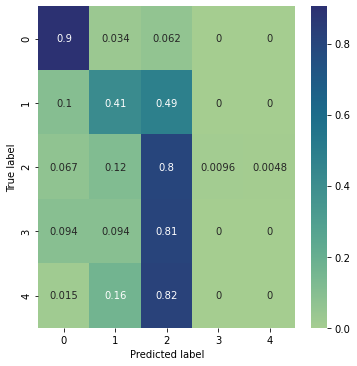


{'1D_ResNet': 61.81129217147827, 'SVC': 3.485785722732544, 'RandomForest': 0.6974883079528809, 'knn': 0.07686519622802734, 'DecisionTree': 0.6289048194885254, 'GradientBoosting': 86.01616549491882, 'XgBoost': 42.34310245513916, 'LightGBM': 13.157261848449707}
{'1D_ResNet': 0.6672007571716589, 'SVC': 0.5914772118666881, 'RandomForest': 0.7570965280033614, 'knn': 0.6371540469202237, 'DecisionTree': 0.6953619745537184, 'GradientBoosting': 0.7371371281119276, 'XgBoost': 0.7636786590449992, 'LightGBM': 0.7705976273810536}
Counter({'LightGBM': 0.7871759890859482, 'RandomForest': 0.781718963165075, 'XgBoost': 0.7748976807639836, 'GradientBoosting': 0.7598908594815825, '1D_ResNet': 0.7066848567530696, 'DecisionTree': 0.6984993178717599, 'SVC': 0.6739427012278308, 'knn': 0.654843110504775})


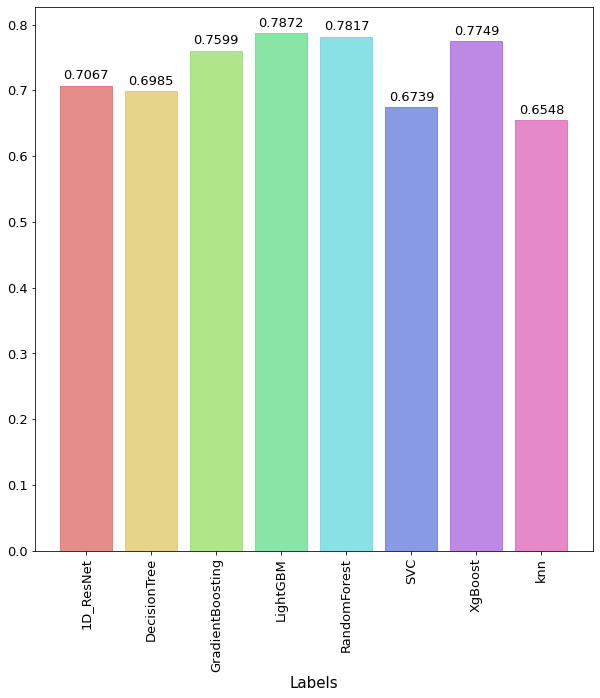

In [32]:
acc_result={}
time_result={}
f1_result={}

dataset_path = '512_aptos_train.csv'
train_data_loader, test_data_loader, num_train_instances, num_test_instances, n_cat = open_file(dataset_path)

data = pd.read_csv(dataset_path)
dataset = data.sample(frac=1).reset_index(drop=True)
dataset = dataset.fillna(0)
X_len = len(dataset.columns)
X = dataset.iloc[:, 3:X_len].values if X_len==515 else dataset.iloc[:, 2:X_len].values
y = dataset.iloc[:, 2].values if X_len==515 else dataset.iloc[:, 1].values
if np.min(y) > 0: 
    y = y-np.min(y)
n_cat = int(max(y))+1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, shuffle=True)

model=Exe_Model(MSResNet)
model.set_model(n_cat)
model.train_model(train_data_loader, test_data_loader, num_train_instances, num_test_instances, es_tolerance=100)
model.cm()

acc_result['1D_ResNet'] = model.best_acc
time_result['1D_ResNet'] = model.train_time
f1_result['1D_ResNet'] = model.f1score

for idx, sk_model in tqdm(enumerate(models)):
    if sk_model=='SVC':
        train_model=SVC(kernel='rbf', C = 10, gamma=0.001)
    elif sk_model=='RandomForest':
        train_model=RandomForestClassifier(criterion='gini', n_estimators=200, random_state=4, n_jobs=10)
    elif sk_model=='knn':
        train_model=KNeighborsClassifier(n_neighbors = n_cat)
    elif sk_model=='DecisionTree':
        train_model=DecisionTreeClassifier(random_state=10)
    elif sk_model=='GradientBoosting':
        train_model=GradientBoostingClassifier(random_state=10)
    elif sk_model=='XgBoost':
        train_model=XGBClassifier(n_estimators=1000)
    elif sk_model=='LightGBM':
        train_model=LGBMClassifier(n_estimators=1000)
    start = time.time()
    train_model.fit(X_train, y_train)
    time_result[sk_model]=time.time() - start
    y_pred = train_model.predict(X_test)
    acc_result[sk_model]=accuracy_score(y_test, y_pred)
    f1_result[sk_model]=f1_score(y_test, y_pred, average='weighted')
    
print(time_result)
print(f1_result)
count_and_plot2(acc_result)

     img  label     glcm1     glcm2     glcm3     glcm4     glcm5     glcm6  \
0  952.0    7.0  0.342711  0.309229  0.342623  0.310533  0.296212  0.309229   

     glcm7     glcm8  ...  dim1_f134  dim1_f135  dim1_f136  dim1_f137  \
0  0.29816  0.310533  ...        0.0        0.0        0.0        0.0   

   dim1_f138  dim1_f139  dim1_f140  dim1_f141  dim1_f142  dim1_f143  
0        0.0        0.0        0.0        0.0        0.0        0.0  

[1 rows x 514 columns]
Counter({7.0: 625, 3.0: 625, 1.0: 625, 0.0: 625, 5.0: 625, 2.0: 625, 4.0: 625, 6.0: 625})


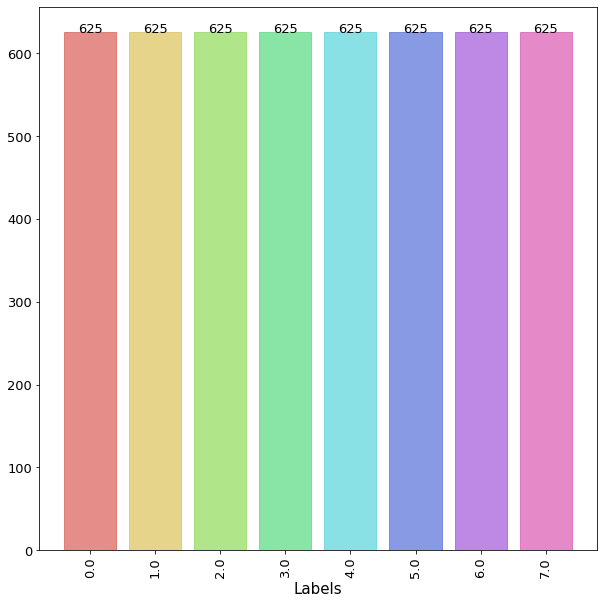

label data shape: (5000,)
Original data shape: (5000, 512)
Test data shape:  torch.Size([1000, 1, 512])
model loaded


/home/seung-ho/anaconda3/envs/cubical/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/seung-ho/anaconda3/envs/cubical/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:117: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Epoch: 0
Training accuracy: 40.8
val accuracy: 40.6
F1 score: 0.34515748533705154



Epoch: 1
Training accuracy: 58.975
val accuracy: 59.0
F1 score: 0.5371072425812151



Epoch: 2
Training accuracy: 60.025
val accuracy: 59.4
F1 score: 0.5235915630655108



Epoch: 3
Training accuracy: 47.375
val accuracy: 49.8
F1 score: 0.4394458601134817



Epoch: 4
Training accuracy: 50.5
val accuracy: 49.8
F1 score: 0.4902491944343673



Epoch: 5
Training accuracy: 48.575
val accuracy: 47.2
F1 score: 0.43642178256970693



Epoch: 6
Training accuracy: 71.825
val accuracy: 73.6
F1 score: 0.7144392973872632



Epoch: 7
Training accuracy: 38.975
val accuracy: 38.4
F1 score: 0.3322472719587958



Epoch: 8
Training accuracy: 75.625
val accuracy: 78.4
F1 score: 0.7769092951640267



Epoch: 9
Training accuracy: 68.2
val accuracy: 69.4
F1 score: 0.6749413717277166



Epoch: 10
Training accuracy: 62.85
val accuracy: 63.0
F1 score: 0.5659967553160525



Epoch: 11
Training accuracy: 68.575
val accuracy: 70.9
F1 score: 0.694014279122432



Epoch: 12
Training accuracy: 66.7
val accuracy: 66.5
F1 score: 0.624635472951992



Epoch: 13
Training accuracy: 50.2
val accuracy: 49.8
F1 score: 0.4485003499646007



Epoch: 14
Training accuracy: 65.8
val accuracy: 68.0
F1 score: 0.6694578510512674



Epoch: 15
Training accuracy: 81.125
val accuracy: 78.5
F1 score: 0.7834893013514616



Epoch: 16
Training accuracy: 50.675
val accuracy: 50.2
F1 score: 0.43335688772643094



Epoch: 17
Training accuracy: 74.125
val accuracy: 74.8
F1 score: 0.748989009231154



Epoch: 18
Training accuracy: 66.75
val accuracy: 66.7
F1 score: 0.6586845504100202



Epoch: 19
Training accuracy: 80.125
val accuracy: 79.3
F1 score: 0.7858171585568796



Epoch: 20
Training accuracy: 80.1
val accuracy: 78.0
F1 score: 0.7763679945922245



Epoch: 21
Training accuracy: 76.25
val accuracy: 75.7
F1 score: 0.7429324845751117



Epoch: 22
Training accuracy: 83.825
val accuracy: 82.5
F1 score: 0.8203359203841619



Epoch: 23
Training accuracy: 86.575
val accuracy: 85.9
F1 score: 0.8585962000553058



Epoch: 24
Training accuracy: 85.075
val accuracy: 81.7
F1 score: 0.819842150868804



Epoch: 25
Training accuracy: 80.875
val accuracy: 80.6
F1 score: 0.8070775526235434



Epoch: 26
Training accuracy: 85.3
val accuracy: 82.1
F1 score: 0.819049904484092



Epoch: 27
Training accuracy: 86.95
val accuracy: 84.0
F1 score: 0.8419037011059463



Epoch: 28
Training accuracy: 77.0
val accuracy: 77.5
F1 score: 0.777722511009622



Epoch: 29
Training accuracy: 73.375
val accuracy: 70.9
F1 score: 0.7054477494214632



Epoch: 30
Training accuracy: 76.95
val accuracy: 75.4
F1 score: 0.7532921425264969



Epoch: 31
Training accuracy: 74.2
val accuracy: 75.5
F1 score: 0.7386897793223252



Epoch: 32
Training accuracy: 81.45
val accuracy: 77.9
F1 score: 0.7763000209348107



Epoch: 33
Training accuracy: 83.05
val accuracy: 80.1
F1 score: 0.8067327238622336



Epoch: 34
Training accuracy: 82.225
val accuracy: 79.6
F1 score: 0.7927791461525835



Epoch: 35
Training accuracy: 85.125
val accuracy: 82.9
F1 score: 0.8225619754771127



Epoch: 36
Training accuracy: 89.375
val accuracy: 86.2
F1 score: 0.8599918577462404



Epoch: 37
Training accuracy: 85.475
val accuracy: 84.7
F1 score: 0.8415347203558371



Epoch: 38
Training accuracy: 84.125
val accuracy: 78.9
F1 score: 0.791856142423974



Epoch: 39
Training accuracy: 76.825
val accuracy: 74.1
F1 score: 0.7381824063777277



Epoch: 40
Training accuracy: 61.025
val accuracy: 59.6
F1 score: 0.5516563893053292



Epoch: 41
Training accuracy: 86.6
val accuracy: 82.4
F1 score: 0.8206106149188991



Epoch: 42
Training accuracy: 81.125
val accuracy: 76.8
F1 score: 0.7727729201802799



Epoch: 43
Training accuracy: 85.5
val accuracy: 81.1
F1 score: 0.8075409859991164



Epoch: 44
Training accuracy: 84.15
val accuracy: 78.4
F1 score: 0.7833121825608077



Epoch: 45
Training accuracy: 76.675
val accuracy: 75.8
F1 score: 0.7584449342117673



Epoch: 46
Training accuracy: 82.375
val accuracy: 77.4
F1 score: 0.7664409127140468



Epoch: 47
Training accuracy: 81.825
val accuracy: 77.7
F1 score: 0.7695357582146671



Epoch: 48
Training accuracy: 85.725
val accuracy: 82.8
F1 score: 0.828599048908603



Epoch: 49
Training accuracy: 95.9
val accuracy: 87.8
F1 score: 0.8784954297831026



Epoch: 50
Training accuracy: 96.725
val accuracy: 88.7
F1 score: 0.8869523970057369



Epoch: 51
Training accuracy: 96.725
val accuracy: 88.7
F1 score: 0.8871078121859286



Epoch: 52
Training accuracy: 96.7
val accuracy: 88.0
F1 score: 0.8803486838199523



Epoch: 53
Training accuracy: 96.975
val accuracy: 88.0
F1 score: 0.8804274831565801



Epoch: 54
Training accuracy: 97.7
val accuracy: 88.1
F1 score: 0.8805260922679404



Epoch: 55
Training accuracy: 97.725
val accuracy: 88.5
F1 score: 0.8853406009432473



Epoch: 56
Training accuracy: 97.625
val accuracy: 88.4
F1 score: 0.8840447384639318



Epoch: 57
Training accuracy: 97.375
val accuracy: 88.2
F1 score: 0.8818280149750385



Epoch: 58
Training accuracy: 97.325
val accuracy: 87.7
F1 score: 0.8782880548541807



Epoch: 59
Training accuracy: 97.575
val accuracy: 87.8
F1 score: 0.8786494526454939



Epoch: 60
Training accuracy: 98.2
val accuracy: 87.8
F1 score: 0.8780513184045127



Epoch: 61
Training accuracy: 98.4
val accuracy: 87.9
F1 score: 0.8790669641462603



Epoch: 62
Training accuracy: 97.975
val accuracy: 88.0
F1 score: 0.8799665166437253



Epoch: 63
Training accuracy: 98.525
val accuracy: 88.7
F1 score: 0.8869300512809343



Epoch: 64
Training accuracy: 98.225
val accuracy: 87.9
F1 score: 0.8796476279515097



Epoch: 65
Training accuracy: 98.4
val accuracy: 88.7
F1 score: 0.886463595337163



Epoch: 66
Training accuracy: 98.55
val accuracy: 88.8
F1 score: 0.8884332311708715



Epoch: 67
Training accuracy: 98.65
val accuracy: 87.7
F1 score: 0.8780813473531391



Epoch: 68
Training accuracy: 98.775
val accuracy: 88.2
F1 score: 0.8823852613619613



Epoch: 69
Training accuracy: 98.625
val accuracy: 88.1
F1 score: 0.8811823238088209



Epoch: 70
Training accuracy: 98.725
val accuracy: 88.8
F1 score: 0.88797121476798



Epoch: 71
Training accuracy: 99.1
val accuracy: 87.7
F1 score: 0.8774640729495014



Epoch: 72
Training accuracy: 98.9
val accuracy: 87.2
F1 score: 0.8728459505199989



Epoch: 73
Training accuracy: 98.875
val accuracy: 87.9
F1 score: 0.879663425691358



Epoch: 74
Training accuracy: 98.75
val accuracy: 87.8
F1 score: 0.8782648834079629



Epoch: 75
Training accuracy: 99.3
val accuracy: 88.1
F1 score: 0.8814033006329546



Epoch: 76
Training accuracy: 99.25
val accuracy: 87.4
F1 score: 0.8744348035219207



Epoch: 77
Training accuracy: 99.15
val accuracy: 88.2
F1 score: 0.8818545744497149



Epoch: 78
Training accuracy: 98.75
val accuracy: 87.6
F1 score: 0.8775004141193129



Epoch: 79
Training accuracy: 99.1
val accuracy: 87.7
F1 score: 0.8780122253217487



Epoch: 80
Training accuracy: 99.275
val accuracy: 87.3
F1 score: 0.8739992754399618



Epoch: 81
Training accuracy: 99.425
val accuracy: 87.8
F1 score: 0.8778560179572558



Epoch: 82
Training accuracy: 99.475
val accuracy: 87.9
F1 score: 0.8792216410375538



Epoch: 83
Training accuracy: 99.1
val accuracy: 88.7
F1 score: 0.8877003718726096



Epoch: 84
Training accuracy: 99.575
val accuracy: 88.1
F1 score: 0.8812803728488877



Epoch: 85
Training accuracy: 99.5
val accuracy: 87.8
F1 score: 0.8790532446387902



Epoch: 86
Training accuracy: 99.475
val accuracy: 87.9
F1 score: 0.8801246062135856



Epoch: 87
Training accuracy: 99.675
val accuracy: 88.1
F1 score: 0.8807473689693781



Epoch: 88
Training accuracy: 99.275
val accuracy: 87.8
F1 score: 0.8788002481398591



Epoch: 89
Training accuracy: 99.2
val accuracy: 86.3
F1 score: 0.8647227368022136



Epoch: 90
Training accuracy: 99.125
val accuracy: 87.7
F1 score: 0.8784636923034926



Epoch: 91
Training accuracy: 99.525
val accuracy: 87.7
F1 score: 0.8785974324115614



Epoch: 92
Training accuracy: 99.675
val accuracy: 88.1
F1 score: 0.8799025321499178



Epoch: 93
Training accuracy: 99.9
val accuracy: 87.7
F1 score: 0.8774892785875259



Epoch: 94
Training accuracy: 99.925
val accuracy: 87.9
F1 score: 0.8791035461875786



Epoch: 95
Training accuracy: 99.95
val accuracy: 87.9
F1 score: 0.8794125731550994



Epoch: 96
Training accuracy: 99.85
val accuracy: 87.7
F1 score: 0.8774473692914675



Epoch: 97
Training accuracy: 99.95
val accuracy: 87.6
F1 score: 0.8758859853504578



Epoch: 98
Training accuracy: 99.95
val accuracy: 88.2
F1 score: 0.8823447965634366



Epoch: 99
Training accuracy: 99.975
val accuracy: 87.7
F1 score: 0.8774330528859203


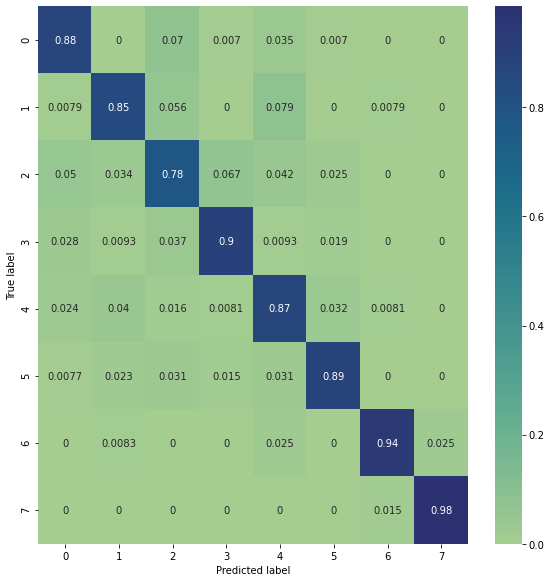


{'1D_ResNet': 86.29778695106506, 'SVC': 4.051560640335083, 'RandomForest': 1.0714848041534424, 'knn': 0.12500500679016113, 'DecisionTree': 1.2606956958770752, 'GradientBoosting': 255.88337349891663, 'XgBoost': 44.33706521987915, 'LightGBM': 12.474993705749512}
{'1D_ResNet': 0.8884332311708715, 'SVC': 0.6857888698429276, 'RandomForest': 0.8341433527009251, 'knn': 0.7434760167620862, 'DecisionTree': 0.7269885427251445, 'GradientBoosting': 0.8322925663933848, 'XgBoost': 0.8429881729224363, 'LightGBM': 0.8502433043354322}
Counter({'1D_ResNet': 0.888, 'LightGBM': 0.851, 'XgBoost': 0.844, 'RandomForest': 0.834, 'GradientBoosting': 0.833, 'knn': 0.743, 'DecisionTree': 0.727, 'SVC': 0.689})


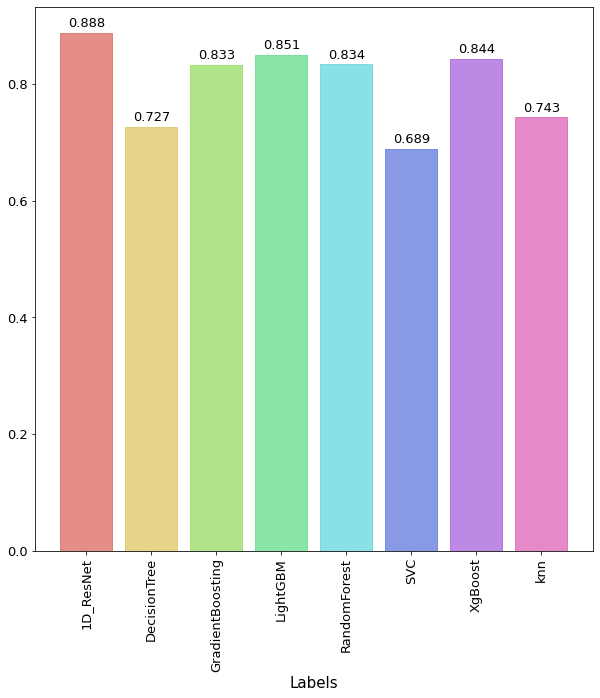

In [31]:
acc_result={}
time_result={}
f1_result={}

dataset_path = '512_colorectal.csv'
train_data_loader, test_data_loader, num_train_instances, num_test_instances, n_cat = open_file(dataset_path)

data = pd.read_csv(dataset_path)
dataset = data.sample(frac=1).reset_index(drop=True)
dataset = dataset.fillna(0)
X_len = len(dataset.columns)
X = dataset.iloc[:, 3:X_len].values if X_len==515 else dataset.iloc[:, 2:X_len].values
y = dataset.iloc[:, 2].values if X_len==515 else dataset.iloc[:, 1].values
if np.min(y) > 0: 
    y = y-np.min(y)
n_cat = int(max(y))+1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, shuffle=True)

model=Exe_Model(MSResNet)
model.set_model(n_cat)
model.train_model(train_data_loader, test_data_loader, num_train_instances, num_test_instances, es_tolerance=50)
model.cm()

acc_result['1D_ResNet'] = model.best_acc
time_result['1D_ResNet'] = model.train_time
f1_result['1D_ResNet'] = model.f1score

for idx, sk_model in tqdm(enumerate(models)):
    if sk_model=='SVC':
        train_model=SVC(kernel='rbf', C = 10, gamma=0.001)
    elif sk_model=='RandomForest':
        train_model=RandomForestClassifier(criterion='gini', n_estimators=200, random_state=4, n_jobs=10)
    elif sk_model=='knn':
        train_model=KNeighborsClassifier(n_neighbors = n_cat)
    elif sk_model=='DecisionTree':
        train_model=DecisionTreeClassifier(random_state=10)
    elif sk_model=='GradientBoosting':
        train_model=GradientBoostingClassifier(random_state=10)
    elif sk_model=='XgBoost':
        train_model=XGBClassifier(n_estimators=1000)
    elif sk_model=='LightGBM':
        train_model=LGBMClassifier(n_estimators=1000)
    start = time.time()
    train_model.fit(X_train, y_train)
    time_result[sk_model]=time.time() - start
    y_pred = train_model.predict(X_test)
    acc_result[sk_model]=accuracy_score(y_test, y_pred)
    f1_result[sk_model]=f1_score(y_test, y_pred, average='weighted')
    
print(time_result)
print(f1_result)
count_and_plot2(acc_result)

     img  label    glcm1     glcm2     glcm3     glcm4     glcm5     glcm6  \
0  109.0    0.0  0.06583  0.056789  0.064265  0.055691  0.050531  0.056789   

      glcm7     glcm8  ...  dim1_f134  dim1_f135  dim1_f136  dim1_f137  \
0  0.049597  0.055691  ...   1.282165   1.281576   1.280057   1.277924   

   dim1_f138  dim1_f139  dim1_f140  dim1_f141  dim1_f142  dim1_f143  
0   1.277049   1.275885   1.275666    1.27524   1.274766   1.274239  

[1 rows x 514 columns]
Counter({0.0: 20000, 1.0: 20000})


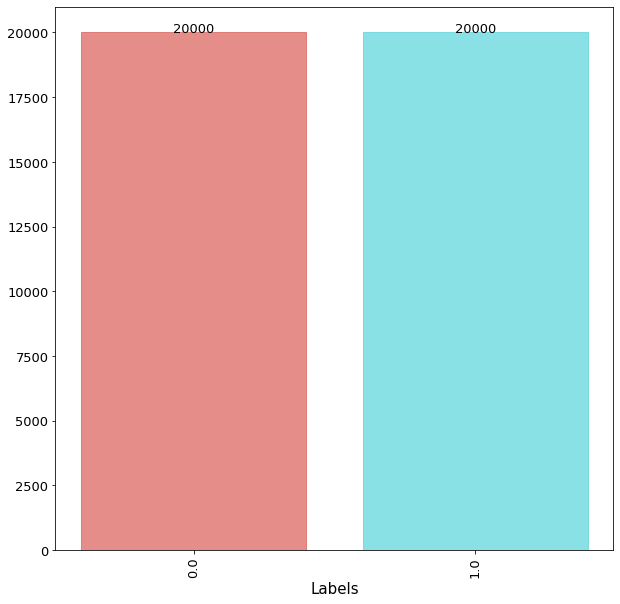

label data shape: (40000,)
Original data shape: (40000, 512)
Test data shape:  torch.Size([8000, 1, 512])
model loaded


/home/seung-ho/anaconda3/envs/cubical/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/seung-ho/anaconda3/envs/cubical/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:117: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Epoch: 0
Training accuracy: 94.421875
val accuracy: 94.325
F1 score: 0.9430401392588998



Epoch: 1
Training accuracy: 93.159375
val accuracy: 92.5625
F1 score: 0.9252712134174037



Epoch: 2
Training accuracy: 98.690625
val accuracy: 98.65
F1 score: 0.9864976265181731



Epoch: 3
Training accuracy: 98.525
val accuracy: 98.5375
F1 score: 0.9853745788433276



Epoch: 4
Training accuracy: 97.1125
val accuracy: 96.975
F1 score: 0.9697164673274461



Epoch: 5
Training accuracy: 99.0625
val accuracy: 99.0875
F1 score: 0.9908743042073732



Epoch: 6
Training accuracy: 95.71875
val accuracy: 95.3375
F1 score: 0.9532976304788314



Epoch: 7
Training accuracy: 65.221875
val accuracy: 64.55
F1 score: 0.5964112670940371



Epoch: 8
Training accuracy: 97.46875
val accuracy: 97.4125
F1 score: 0.97410307130496



Epoch: 9
Training accuracy: 99.034375
val accuracy: 99.1125
F1 score: 0.9911251837482992



Epoch: 10
Training accuracy: 96.828125
val accuracy: 96.7125
F1 score: 0.9671018040651492



Epoch: 11
Training accuracy: 98.453125
val accuracy: 98.4125
F1 score: 0.9841242967790993



Epoch: 12
Training accuracy: 96.621875
val accuracy: 96.6625
F1 score: 0.9665794023655822



Epoch: 13
Training accuracy: 99.14375
val accuracy: 99.225
F1 score: 0.9922496075847324



Epoch: 14
Training accuracy: 92.575
val accuracy: 92.075
F1 score: 0.9203173153006463



Epoch: 15
Training accuracy: 94.278125
val accuracy: 93.7875
F1 score: 0.9376758631136679



Epoch: 16
Training accuracy: 98.765625
val accuracy: 98.6625
F1 score: 0.9866250470256175



Epoch: 17
Training accuracy: 98.621875
val accuracy: 98.2625
F1 score: 0.9826239262587448



Epoch: 18
Training accuracy: 99.128125
val accuracy: 99.1
F1 score: 0.9909994227577837



Epoch: 19
Training accuracy: 98.653125
val accuracy: 98.7
F1 score: 0.9869968216897943



Epoch: 20
Training accuracy: 98.928125
val accuracy: 99.0125
F1 score: 0.9901238710063163



Epoch: 21
Training accuracy: 98.9875
val accuracy: 98.9625
F1 score: 0.9896247381564354



Epoch: 22
Training accuracy: 89.715625
val accuracy: 89.0875
F1 score: 0.8896971624455116



Epoch: 23
Training accuracy: 98.20625
val accuracy: 98.15
F1 score: 0.9814915811007515



Epoch: 24
Training accuracy: 99.371875
val accuracy: 99.325
F1 score: 0.993250071723932



Epoch: 25
Training accuracy: 98.921875
val accuracy: 98.825
F1 score: 0.9882500793125446



Epoch: 26
Training accuracy: 99.31875
val accuracy: 99.125
F1 score: 0.9912502078176955



Epoch: 27
Training accuracy: 98.946875
val accuracy: 98.9625
F1 score: 0.9896233551692477



Epoch: 28
Training accuracy: 99.4
val accuracy: 99.3125
F1 score: 0.9931251204264719



Epoch: 29
Training accuracy: 98.85
val accuracy: 98.8625
F1 score: 0.9886231190955788



Epoch: 30
Training accuracy: 99.1625
val accuracy: 99.125
F1 score: 0.9912491247759426



Epoch: 31
Training accuracy: 99.36875
val accuracy: 99.2875
F1 score: 0.9928750820545835



Epoch: 32
Training accuracy: 98.946875
val accuracy: 99.0
F1 score: 0.9899989434710104



Epoch: 33
Training accuracy: 98.909375
val accuracy: 98.7625
F1 score: 0.987624919755828



Epoch: 34
Training accuracy: 98.665625
val accuracy: 98.45
F1 score: 0.9844948433413223



Epoch: 35
Training accuracy: 99.29375
val accuracy: 99.075
F1 score: 0.9907502185356754



Epoch: 36
Training accuracy: 99.1875
val accuracy: 99.225
F1 score: 0.992249309115265



Epoch: 37
Training accuracy: 99.475
val accuracy: 99.3
F1 score: 0.9930000323777703



Epoch: 38
Training accuracy: 99.50625
val accuracy: 99.3375
F1 score: 0.9933749918214682



Epoch: 39
Training accuracy: 99.496875
val accuracy: 99.2875
F1 score: 0.9928750820545835



Epoch: 40
Training accuracy: 99.240625
val accuracy: 99.125
F1 score: 0.9912492199688474



Epoch: 41
Training accuracy: 94.00625
val accuracy: 92.8625
F1 score: 0.928326381571314



Epoch: 42
Training accuracy: 99.396875
val accuracy: 99.1875
F1 score: 0.9918748228764541



Epoch: 43
Training accuracy: 99.575
val accuracy: 99.2375
F1 score: 0.9923751507200144



Epoch: 44
Training accuracy: 99.6125
val accuracy: 99.3625
F1 score: 0.9936250841754788



Epoch: 45
Training accuracy: 99.43125
val accuracy: 99.3375
F1 score: 0.9933748775251686



Epoch: 46
Training accuracy: 99.221875
val accuracy: 98.9125
F1 score: 0.9891252475798894



Epoch: 47
Training accuracy: 99.5875
val accuracy: 99.3375
F1 score: 0.9933748327986878



Epoch: 48
Training accuracy: 99.65625
val accuracy: 99.3625
F1 score: 0.9936249586576593



Epoch: 49
Training accuracy: 99.746875
val accuracy: 99.45
F1 score: 0.9945000254396766



Epoch: 50
Training accuracy: 99.784375
val accuracy: 99.4125
F1 score: 0.9941250335086494



Epoch: 51
Training accuracy: 99.796875
val accuracy: 99.4375
F1 score: 0.9943750067682051



Epoch: 52
Training accuracy: 99.775
val accuracy: 99.3375
F1 score: 0.9933750978283327



Epoch: 53
Training accuracy: 99.8
val accuracy: 99.3375
F1 score: 0.9933751160473275



Epoch: 54
Training accuracy: 99.81875
val accuracy: 99.4
F1 score: 0.9940000840053763



Epoch: 55
Training accuracy: 99.83125
val accuracy: 99.4125
F1 score: 0.9941250070690144



Epoch: 56
Training accuracy: 99.8375
val accuracy: 99.3875
F1 score: 0.9938749767417563



Epoch: 57
Training accuracy: 99.84375
val accuracy: 99.325
F1 score: 0.9932500945060485



Epoch: 58
Training accuracy: 99.85
val accuracy: 99.35
F1 score: 0.9935001251311314



Epoch: 59
Training accuracy: 99.859375
val accuracy: 99.375
F1 score: 0.99375



Epoch: 60
Training accuracy: 99.85
val accuracy: 99.4
F1 score: 0.9940000930055862



Epoch: 61
Training accuracy: 99.85
val accuracy: 99.425
F1 score: 0.9942498842659442



Epoch: 62
Training accuracy: 99.875
val accuracy: 99.35
F1 score: 0.9935000910058245



Epoch: 63
Training accuracy: 99.859375
val accuracy: 99.4375
F1 score: 0.9943750197771288



Epoch: 64
Training accuracy: 99.85625
val accuracy: 99.2375
F1 score: 0.9923751807410753



Epoch: 65
Training accuracy: 99.89375
val accuracy: 99.35
F1 score: 0.9934999106141843



Epoch: 66
Training accuracy: 99.90625
val accuracy: 99.375
F1 score: 0.9937501054746829



Epoch: 67
Training accuracy: 99.9125
val accuracy: 99.4125
F1 score: 0.9941250335086494



Epoch: 68
Training accuracy: 99.903125
val accuracy: 99.3125
F1 score: 0.9931251285905124



Epoch: 69
Training accuracy: 99.928125
val accuracy: 99.3875
F1 score: 0.9938750215350958

 Best validation accuracy: 0.9945    when epoch: 49
triain time: 465.8653812408447


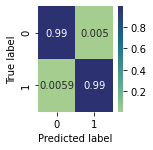


{'1D_ResNet': 465.86541986465454, 'SVC': 213.31859683990479, 'RandomForest': 7.750104665756226, 'knn': 1.9681711196899414, 'DecisionTree': 10.292692184448242, 'GradientBoosting': 252.37444519996643, 'XgBoost': 58.838353633880615, 'LightGBM': 11.376654863357544}
{'1D_ResNet': 0.9945000254396766, 'SVC': 0.9547059460447748, 'RandomForest': 0.9918751921038539, 'knn': 0.88438460839599, 'DecisionTree': 0.9876250976620509, 'GradientBoosting': 0.9887501054852321, 'XgBoost': 0.9932500219412081, 'LightGBM': 0.9947499822780203}
Counter({'LightGBM': 0.99475, '1D_ResNet': 0.9945, 'XgBoost': 0.99325, 'RandomForest': 0.991875, 'GradientBoosting': 0.98875, 'DecisionTree': 0.987625, 'SVC': 0.95475, 'knn': 0.88475})


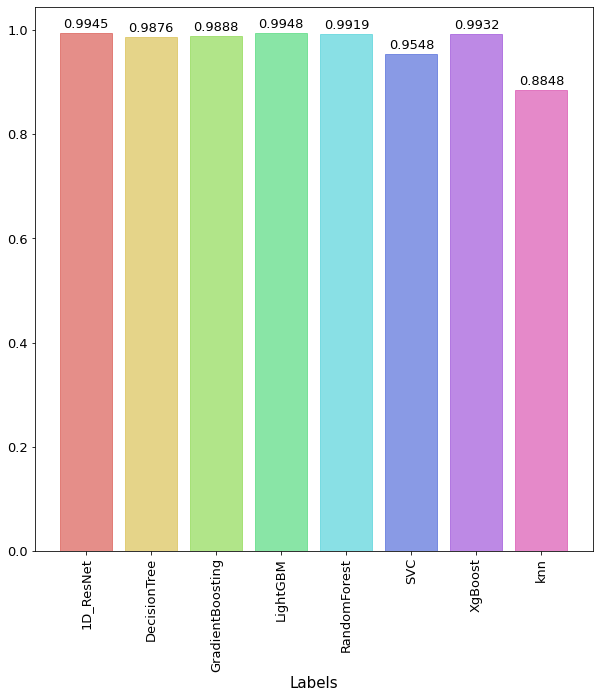

In [29]:
acc_result={}
time_result={}
f1_result={}

dataset_path = '512_concrete.csv'
train_data_loader, test_data_loader, num_train_instances, num_test_instances, n_cat = open_file(dataset_path)

data = pd.read_csv(dataset_path)
dataset = data.sample(frac=1).reset_index(drop=True)
dataset = dataset.fillna(0)
X_len = len(dataset.columns)
X = dataset.iloc[:, 3:X_len].values if X_len==515 else dataset.iloc[:, 2:X_len].values
y = dataset.iloc[:, 2].values if X_len==515 else dataset.iloc[:, 1].values
if np.min(y) > 0: 
    y = y-np.min(y)
n_cat = int(max(y))+1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, shuffle=True)

model=Exe_Model(MSResNet)
model.set_model(n_cat)
model.train_model(train_data_loader, test_data_loader, num_train_instances, num_test_instances, es_tolerance=20)
model.cm()

acc_result['1D_ResNet'] = model.best_acc
time_result['1D_ResNet'] = model.train_time
f1_result['1D_ResNet'] = model.f1score

for idx, sk_model in tqdm(enumerate(models)):
    if sk_model=='SVC':
        train_model=SVC(kernel='rbf', C = 10, gamma=0.001)
    elif sk_model=='RandomForest':
        train_model=RandomForestClassifier(criterion='gini', n_estimators=200, random_state=4, n_jobs=10)
    elif sk_model=='knn':
        train_model=KNeighborsClassifier(n_neighbors = n_cat)
    elif sk_model=='DecisionTree':
        train_model=DecisionTreeClassifier(random_state=10)
    elif sk_model=='GradientBoosting':
        train_model=GradientBoostingClassifier(random_state=10)
    elif sk_model=='XgBoost':
        train_model=XGBClassifier(n_estimators=1000)
    elif sk_model=='LightGBM':
        train_model=LGBMClassifier(n_estimators=1000)
    start = time.time()
    train_model.fit(X_train, y_train)
    time_result[sk_model]=time.time() - start
    y_pred = train_model.predict(X_test)
    acc_result[sk_model]=accuracy_score(y_test, y_pred)
    f1_result[sk_model]=f1_score(y_test, y_pred, average='weighted')
    
print(time_result)
print(f1_result)
count_and_plot2(acc_result)

{'1D_ResNet': 61.81129217147827, 'SVC': 3.485785722732544, 'RandomForest': 0.6974883079528809, 'knn': 0.07686519622802734, 'DecisionTree': 0.6289048194885254, 'GradientBoosting': 86.01616549491882, 'XgBoost': 42.34310245513916, 'LightGBM': 13.157261848449707}
{'1D_ResNet': 0.6672007571716589, 'SVC': 0.5914772118666881, 'RandomForest': 0.7570965280033614, 'knn': 0.6371540469202237, 'DecisionTree': 0.6953619745537184, 'GradientBoosting': 0.7371371281119276, 'XgBoost': 0.7636786590449992, 'LightGBM': 0.7705976273810536}
Counter({'LightGBM': 0.7871759890859482, 'RandomForest': 0.781718963165075, 'XgBoost': 0.7748976807639836, 'GradientBoosting': 0.7598908594815825, '1D_ResNet': 0.7326, 'DecisionTree': 0.6984993178717599, 'SVC': 0.6739427012278308, 'knn': 0.654843110504775})


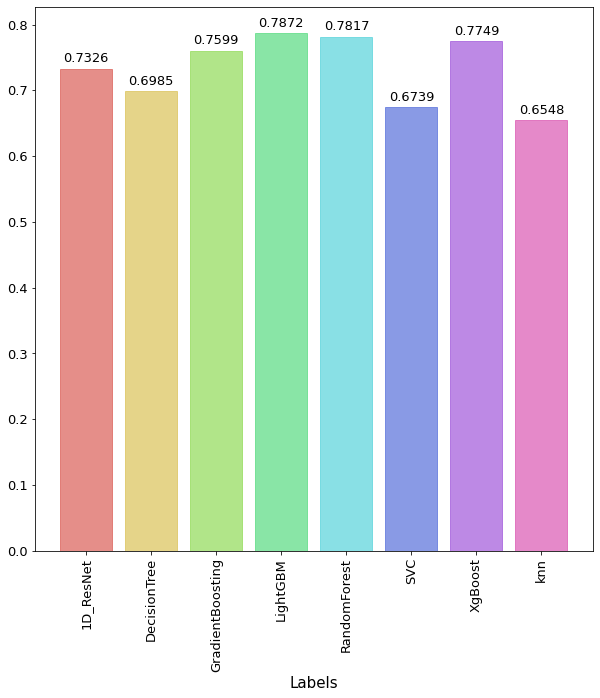

In [34]:
acc_result['1D_ResNet']=0.7326
print(time_result)
print(f1_result)
count_and_plot2(acc_result)